# Truncated SVD в задаче сжатия нейронных сетей

In [1]:
from itertools import product
from matplotlib import pyplot as plt
import pandas as pd
import torch
from torchvision import models
from utils.common import *
from utils.svd_factorization import *

In [2]:
BATCH_SIZE = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 10
LR = 1e-4
NUM_WORKERS = 4
WEIGHT_DECAY = 1e-5

## Эксперименты с MNIST

In [3]:
train_dataset, test_dataset = prepare_dataset("MNIST")

In [4]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False
)

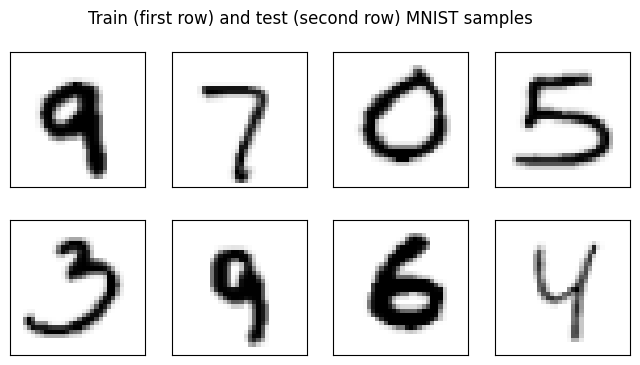

In [5]:
train_sample_ids = torch.randint(0, len(train_dataset), (4,))
test_sample_ids = torch.randint(0, len(test_dataset), (4,))

fig, ax = plt.subplots(2, 4, figsize=(8, 4))
fig.suptitle("Train (first row) and test (second row) MNIST samples")

for i, (train_id, test_id) in enumerate(zip(train_sample_ids, test_sample_ids)):
    ax[0, i].imshow(train_dataset[train_id][0][0, ...], cmap="Greys")
    ax[1, i].imshow(test_dataset[test_id][0][0, ...], cmap="Greys")

for i, j in product(range(2), range(4)):
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
    
plt.show()

In [6]:
vgg11 = models.vgg11()
vgg11

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [7]:
total_params = count_parameters(vgg11)
nn_blocks = {
    "features" : vgg11.features,
    "avgpool" : vgg11.avgpool,
    "classifier" : vgg11.classifier
}
df = pd.DataFrame(
    index=nn_blocks.keys(),
    data={
        "num_features" : [ count_parameters(block) for block in nn_blocks.values() ],
        "%_features" : [ 100.0 * count_parameters(block) / total_params for block in nn_blocks.values() ]
    }
)
print(f"Total parameters for VGG11: {total_params}")
df

Total parameters for VGG11: 132863336


,num_features,%_features
features,9220480,6.939823
avgpool,0,0.000000
classifier,123642856,93.060177


In [8]:
vgg11.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1))
vgg11.classifier = get_vgg11_classifier(num_classes=10)
train_classification(vgg11, train_dataloader, epochs=EPOCHS, device=DEVICE, path="vgg11_mnist_state_dict")

Loss: 0.006233324762433767: 100%|██████████| 235/235 [00:21<00:00, 11.03it/s] 


In [9]:
test_model(vgg11, test_dataloader, device=DEVICE)

100%|██████████| 40/40 [00:01<00:00, 23.05it/s]

Correctly classified targets: 9926 / 10000
Total accuracy: 99.25999450683594%


tensor(99.2600, device='cuda:0')

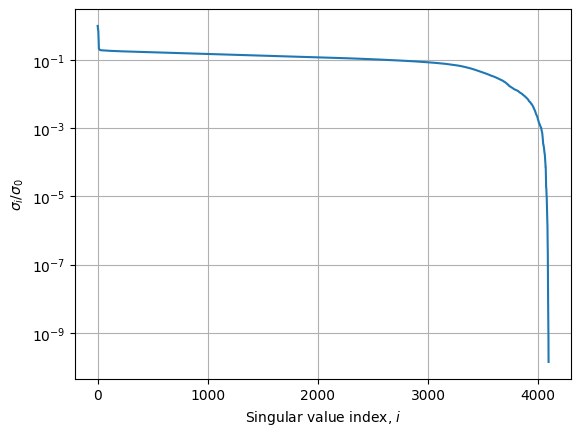

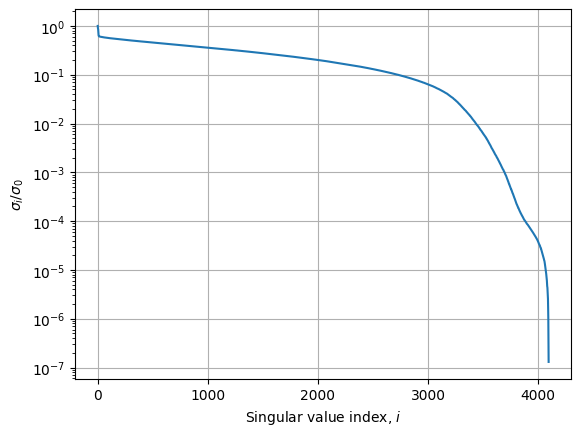

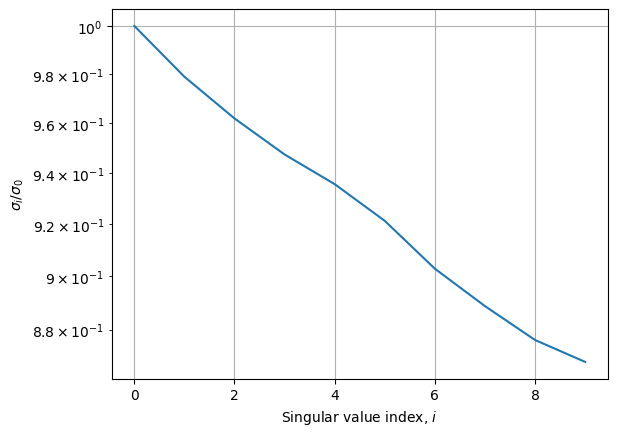

In [10]:
compressed_matrices = get_linear_svd_layers(vgg11.classifier, device=DEVICE)
for (U, S, Vh, bias) in compressed_matrices:
    plot_singular_values(S)

In [11]:
ranks = torch.arange(2, 4002, 100)
test_results = []
for rank in ranks:
    vgg11.to('cpu')
    vgg11.classifier = get_compressed_classifier_by_rank(compressed_matrices, rank)
    test_results.append(test_model(vgg11, test_dataloader, device=DEVICE, log=False).cpu().item())

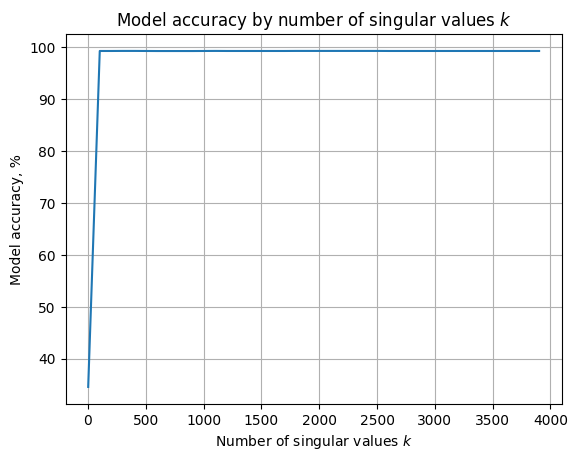

In [12]:
plt.plot(ranks, test_results)
plt.title(r"Model accuracy by number of singular values $k$")
plt.xlabel(r"Number of singular values $k$")
plt.ylabel(r"Model accuracy, %")
plt.grid(True)
plt.show()

In [13]:
vgg11.to('cpu')
vgg11.classifier = get_compressed_classifier_by_rank(compressed_matrices, 250)
train_classification(vgg11, train_dataloader, epochs=EPOCHS, device=DEVICE)

Loss: 0.0003821296850219369: 100%|██████████| 235/235 [00:10<00:00, 21.76it/s] 


In [14]:
test_model(vgg11, test_dataloader, device=DEVICE)

100%|██████████| 40/40 [00:01<00:00, 23.50it/s]

Correctly classified targets: 9935 / 10000
Total accuracy: 99.3499984741211%


tensor(99.3500, device='cuda:0')

In [15]:
compression_params = torch.linspace(1, 1000, 41).int()
test_accuracies = []
model_params = []
for compression_rate in compression_params:
    vgg11.to('cpu')
    vgg11.classifier = get_compressed_classifier_by_compression_rate(compressed_matrices, compression_rate)
    test_accuracies.append(test_model(vgg11, test_dataloader, device=DEVICE, log=False).cpu().item())
    model_params.append(count_parameters(vgg11.classifier))

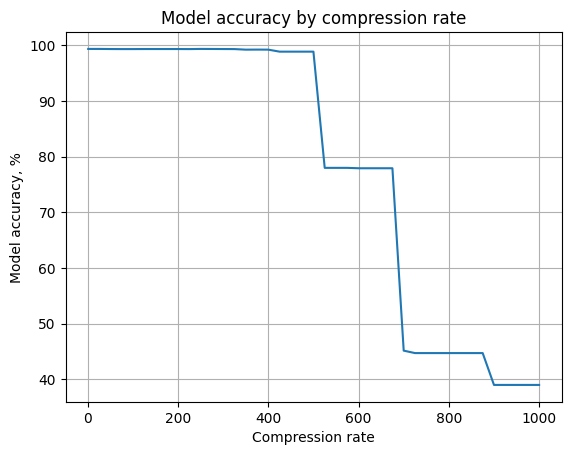

In [16]:
plt.plot(compression_params, test_accuracies)
plt.title(r"Model accuracy by compression rate")
plt.xlabel(r"Compression rate")
plt.ylabel(r"Model accuracy, %")
plt.grid(True)
plt.show()

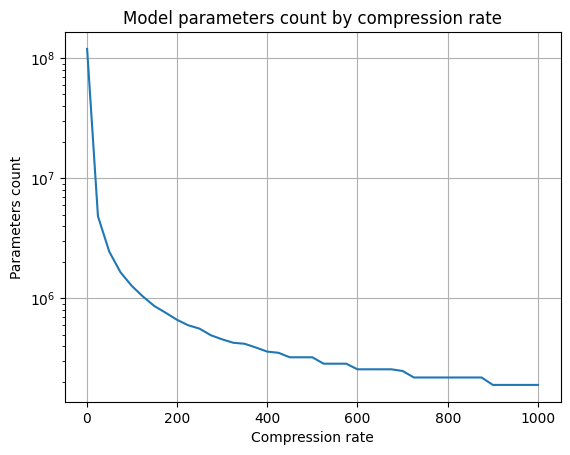

In [17]:
plt.plot(compression_params, model_params)
plt.title(r"Model parameters count by compression rate")
plt.xlabel(r"Compression rate")
plt.ylabel(r"Parameters count")
plt.yscale("log")
plt.grid(True)
plt.show()

In [18]:
df = pd.DataFrame({
    'compression' : compression_params,
    'accuracy' : test_accuracies,
    'parameters' : model_params
})
df.to_csv('comp_acc_svd_mnist.csv', index=False)

In [19]:
vgg11.to('cpu')
vgg11.classifier = get_compressed_classifier_by_compression_rate(compressed_matrices, 200)
train_classification(vgg11, train_dataloader, epochs=EPOCHS, device=DEVICE)

Loss: 1.3170517377147917e-05: 100%|██████████| 235/235 [00:10<00:00, 23.31it/s]


In [20]:
test_model(vgg11, test_dataloader, device=DEVICE)

100%|██████████| 40/40 [00:01<00:00, 23.89it/s]

Correctly classified targets: 9938 / 10000
Total accuracy: 99.37999725341797%


tensor(99.3800, device='cuda:0')

## Эксперименты с CIFAR10

In [21]:
train_dataset, test_dataset = prepare_dataset("CIFAR10")

Files already downloaded and verified
Files already downloaded and verified


In [22]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False
)

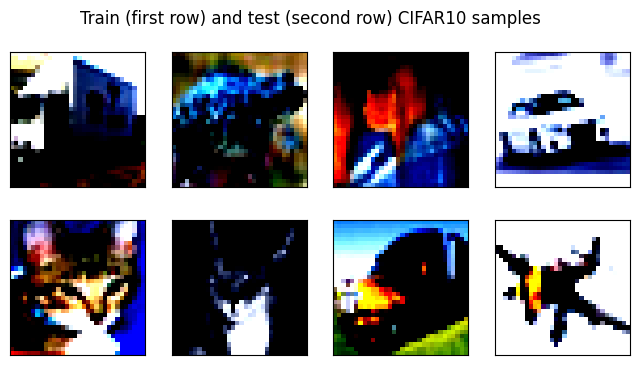

In [23]:
train_sample_ids = torch.randint(0, len(train_dataset), (4,))
test_sample_ids = torch.randint(0, len(test_dataset), (4,))

fig, ax = plt.subplots(2, 4, figsize=(8, 4))
fig.suptitle("Train (first row) and test (second row) CIFAR10 samples")

for i, (train_id, test_id) in enumerate(zip(train_sample_ids, test_sample_ids)):
    ax[0, i].imshow(train_dataset[train_id][0].permute(1, 2, 0))
    ax[1, i].imshow(test_dataset[test_id][0].permute(1, 2, 0))

for i, j in product(range(2), range(4)):
    ax[i, j].set_xticks([])
    ax[i, j].set_yticks([])
    
plt.show()

In [24]:
vgg11 = models.vgg11()
vgg11.classifier = get_vgg11_classifier(num_classes=10)
train_classification(vgg11, train_dataloader, epochs=EPOCHS, device=DEVICE, path="vgg11_cifar10_state_dict")

Loss: 0.7528819441795349: 100%|██████████| 196/196 [00:18<00:00, 10.84it/s]


In [25]:
test_model(vgg11, test_dataloader, device=DEVICE)

100%|██████████| 40/40 [00:01<00:00, 24.20it/s]

Correctly classified targets: 6559 / 10000
Total accuracy: 65.58999633789062%


tensor(65.5900, device='cuda:0')

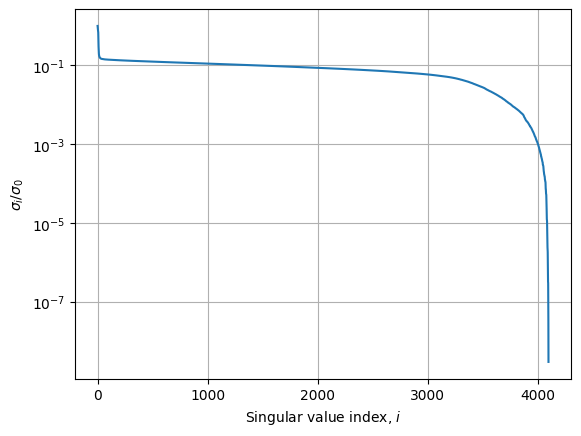

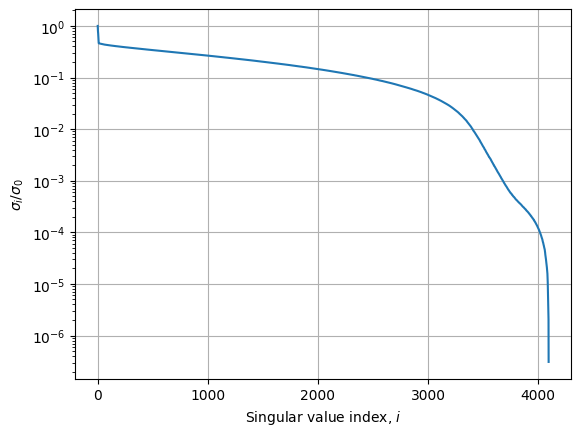

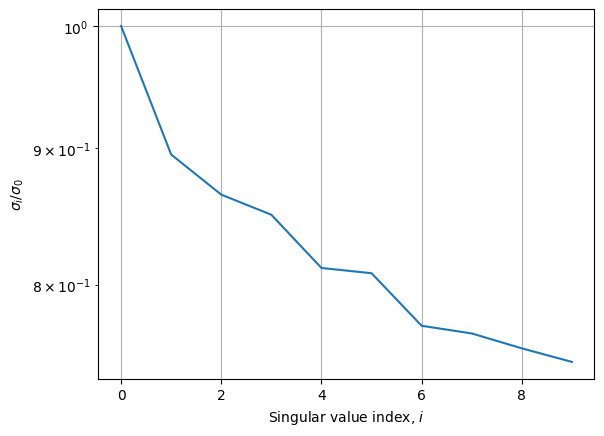

In [26]:
compressed_matrices = get_linear_svd_layers(vgg11.classifier, device=DEVICE)
for (U, S, Vh, bias) in compressed_matrices:
    plot_singular_values(S)

In [27]:
ranks = torch.arange(2, 4002, 100)
test_results = []
for rank in ranks:
    vgg11.to('cpu')
    vgg11.classifier = get_compressed_classifier_by_rank(compressed_matrices, rank)
    test_results.append(test_model(vgg11, test_dataloader, device=DEVICE, log=False).cpu().item())

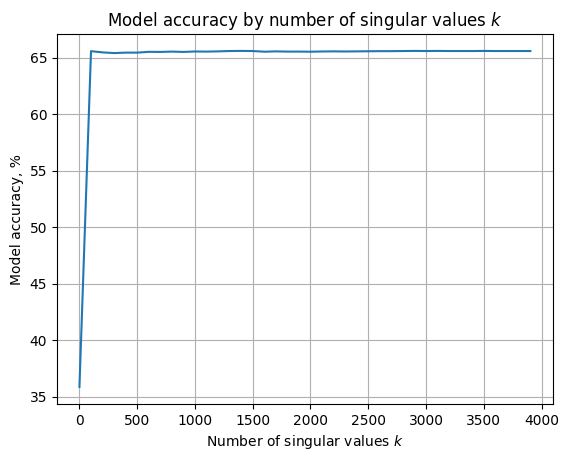

In [28]:
plt.plot(ranks, test_results)
plt.title(r"Model accuracy by number of singular values $k$")
plt.xlabel(r"Number of singular values $k$")
plt.ylabel(r"Model accuracy, %")
plt.grid(True)
plt.show()

In [29]:
vgg11.to('cpu')
vgg11.classifier = get_compressed_classifier_by_rank(compressed_matrices, 250)
train_classification(vgg11, train_dataloader, epochs=EPOCHS, device=DEVICE)

Loss: 0.2876775860786438: 100%|██████████| 196/196 [00:09<00:00, 21.37it/s] 


In [30]:
test_model(vgg11, test_dataloader, device=DEVICE)

100%|██████████| 40/40 [00:01<00:00, 25.71it/s]

Correctly classified targets: 6879 / 10000
Total accuracy: 68.79000091552734%


tensor(68.7900, device='cuda:0')

In [31]:
compression_params = torch.linspace(1, 1000, 41).int()
test_accuracies = []
model_params = []
for compression_rate in compression_params:
    vgg11.to('cpu')
    vgg11.classifier = get_compressed_classifier_by_compression_rate(compressed_matrices, compression_rate)
    test_accuracies.append(test_model(vgg11, test_dataloader, device=DEVICE, log=False).cpu().item())
    model_params.append(count_parameters(vgg11.classifier))

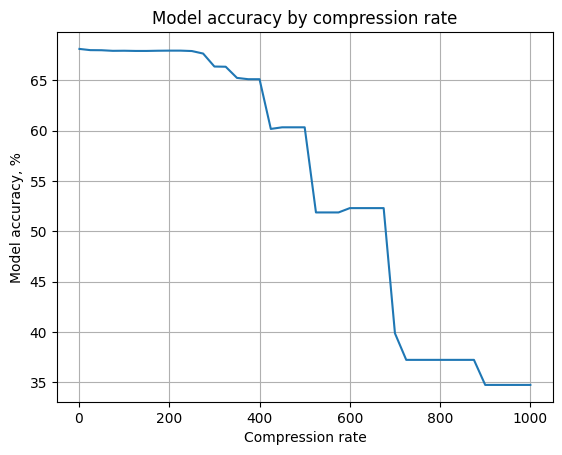

In [32]:
plt.plot(compression_params, test_accuracies)
plt.title(r"Model accuracy by compression rate")
plt.xlabel(r"Compression rate")
plt.ylabel(r"Model accuracy, %")
plt.grid(True)
plt.show()

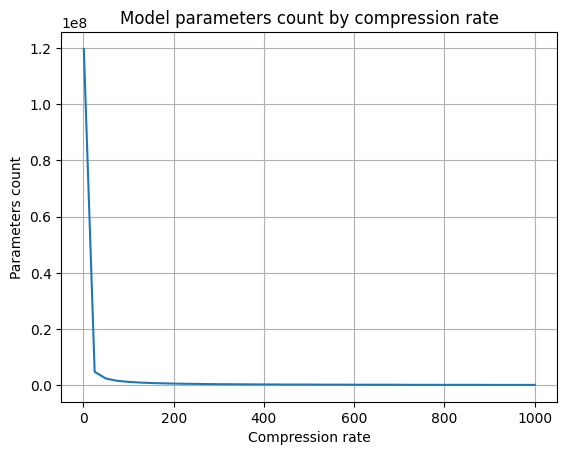

In [33]:
plt.plot(compression_params, model_params)
plt.title(r"Model parameters count by compression rate")
plt.xlabel(r"Compression rate")
plt.ylabel(r"Parameters count")
plt.grid(True)
plt.show()

In [34]:
df = pd.DataFrame({
    'compression' : compression_params.int(),
    'accuracy' : test_accuracies,
    'parameters' : model_params
})
df.to_csv('comp_acc_svd_cifar10.csv', index=False)

In [35]:
vgg11.to('cpu')
vgg11.classifier = get_compressed_classifier_by_compression_rate(compressed_matrices, 200)
train_classification(vgg11, train_dataloader, epochs=EPOCHS, device=DEVICE)

Loss: 0.14477917551994324: 100%|██████████| 196/196 [00:08<00:00, 23.12it/s]


In [36]:
test_model(vgg11, test_dataloader, device=DEVICE)

100%|██████████| 40/40 [00:01<00:00, 22.66it/s]

Correctly classified targets: 6855 / 10000
Total accuracy: 68.54999542236328%


tensor(68.5500, device='cuda:0')